In [1]:
import time
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
import xgboost as xgb
from scipy import interp

from collections import Counter
from sklearn import metrics, preprocessing, linear_model
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_score, recall_score,
    f1_score, accuracy_score, classification_report
)
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, StratifiedKFold
)
from sklearn.manifold import TSNE
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Drop the 'Time' column from the DataFrame
df = df.drop("Time", axis=1)
df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Assign the 'Class' column as the target variable y
y = df["Class"]

# Create the feature matrix X by dropping the 'Class' column
X = df.drop("Class", axis=1)

# Print the shapes of y and X
print("Shape of y:", y.shape)
print("Shape of X:", X.shape)


Shape of y: (284807,)
Shape of X: (284807, 29)


In [5]:
# Splitting the data into 80:20 train test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (227845, 29)
Shape of X_test: (56962, 29)
Shape of y_train: (227845,)
Shape of y_test: (56962,)


In [6]:
print("Fraudulent Count for Full data:", np.sum(y))
print("Fraudulent Count for Train data:", np.sum(y_train))
print("Fraudulent Count for Test data:", np.sum(y_test))


Fraudulent Count for Full data: 492
Fraudulent Count for Train data: 394
Fraudulent Count for Test data: 98


In [7]:
X_test_saved = X_test.copy()
y_test_saved = y_test.copy()
print("Testing set saved for evaluation.")


Testing set saved for evaluation.


In [8]:
# Initialize the RobustScaler
scaler = RobustScaler()

# Scaling the "Amount" feature in the training data
X_train[["Amount"]] = scaler.fit_transform(X_train[["Amount"]])

# Scaling the "Amount" feature in the test data
X_test[["Amount"]] = scaler.transform(X_test[["Amount"]])

# Calculate skewness of features
var = X_train.columns
skewness_list = []
for col in var:
    skewness_list.append(X_train[col].skew())

# Create a DataFrame to store skewness values
skewness_df = pd.DataFrame({"Features": var, "Skewness": skewness_list})
skewness_df.set_index("Features", inplace=True)
skewness_df

# Identify skewed features
skewed_features = skewness_df[(skewness_df["Skewness"] > 1) | (skewness_df["Skewness"] < -1)].index
skewed_features.tolist()

# Importing the required library
from sklearn import preprocessing

# Instantiate the PowerTransformer
pt = preprocessing.PowerTransformer(method='yeo-johnson', copy=True)

# Fit and transform the training data
X_train_pt = pt.fit_transform(X_train)
y_train_pt = y_train

# Transform the test data using the same transformer
X_test_pt = pt.transform(X_test)
y_test_pt = y_test


In [9]:
# Display the power-transformed features
print(X_train_pt)


[[ 1.33618788 -0.54484524 -0.96560586 ...  0.18226012 -0.09086395
  -0.84312016]
 [ 1.42577426 -0.11673724 -1.77657609 ... -0.00550109 -0.20559691
  -1.07812706]
 [-0.75438698  0.33048345  0.39988107 ...  0.08314307  0.57984412
   1.43122753]
 ...
 [ 0.52096648 -0.03765332  0.22167732 ...  0.06556876  0.08664086
   0.39825955]
 [ 0.70400402  0.11684072  0.09210173 ... -0.1603766  -0.00883583
  -1.20086971]
 [-0.57696779  0.45583121  1.4321219  ...  0.94608931  0.64393801
  -0.86019457]]


In [10]:
# Conducting cross-validation for both X_train and y_train datasets.
# Initialize a StratifiedKFold cross-validator for performing cross-validation.

num_splits = 3
random_state = None
shuffle_data = False  # The shuffling of data is disabled by setting shuffle to False in order to maintain consistent results during cross-validation.

skf = StratifiedKFold(n_splits=num_splits, random_state=random_state, shuffle=shuffle_data)


:::: XGBoost Classifier Exploration ::::
Processing for Learning Rate: 0.001 ...
Training set: [ 75936  75937  75938 ... 227842 227843 227844] | Validation set: [    0     1     2 ... 83545 84117 84974] | Time taken: 17.80 seconds
Training set: [     0      1      2 ... 227842 227843 227844] | Validation set: [ 75936  75937  75938 ... 153006 153116 153683] | Time taken: 17.47 seconds
Training set: [     0      1      2 ... 153006 153116 153683] | Validation set: [151894 151895 151896 ... 227842 227843 227844] | Time taken: 17.20 seconds
Validation AUC Score: 0.9147 | Average Precision: 0.8876 | Average Recall: 0.7005 | Average F1 Score: 0.7830
------------------------------------------------------------------------------------------------------------------------
Processing for Learning Rate: 0.01 ...
Training set: [ 75936  75937  75938 ... 227842 227843 227844] | Validation set: [    0     1     2 ... 83545 84117 84974] | Time taken: 17.40 seconds
Training set: [     0      1      2 ..

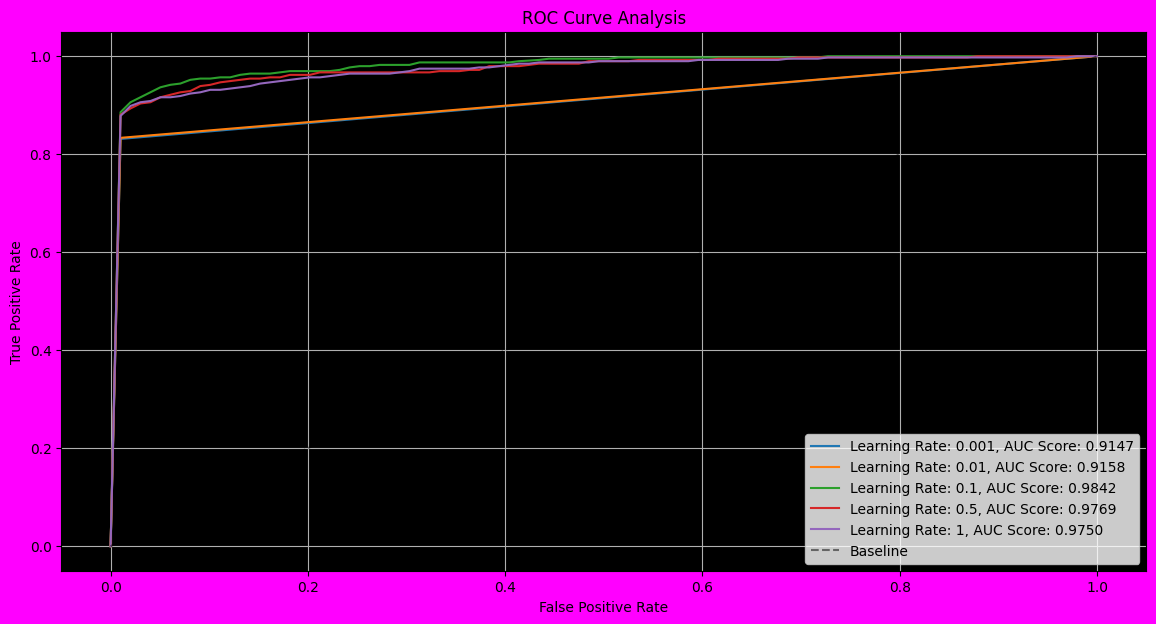

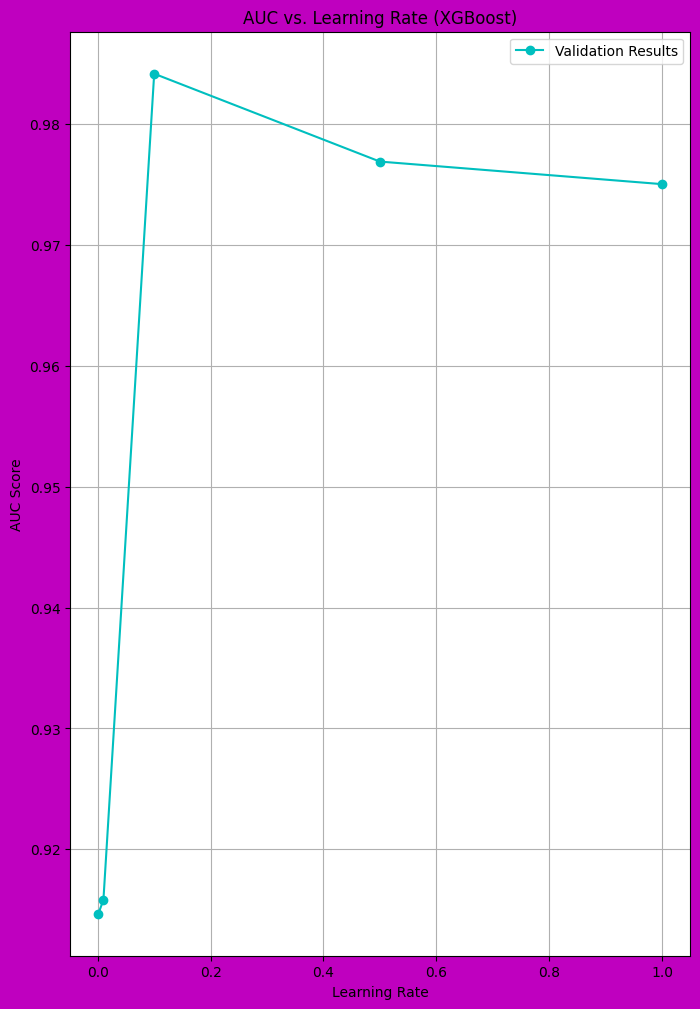



:::: Summary of Results & Optimal Parameters ::::
AUC Scores for different Learning Rates: [0.9146689905140697, 0.9158049073889138, 0.9841667735268659, 0.9768983110411552, 0.975031581156494]
Top Learning Rate: 0.1 | AUC Score: 0.9842 | Precision: 0.9233 | Recall: 0.7792 | F1 Score: 0.8448



In [11]:
print("=" * 120)

print(":::: XGBoost Classifier Exploration ::::")

# Set learning rates
lr_list = [0.001, 0.01, 0.1, 0.5, 1]

# Lists to capture metric averages
avg_roc_auc = []
avg_precision = []
avg_recall = []
avg_f1 = []
avg_fpr = np.linspace(0, 1, 100)

fig, ax2 = plt.subplots(figsize=(14, 7), facecolor='fuchsia')
ax2.set_facecolor('black')

# Evaluate for each learning rate
for lr in lr_list:
    print(f"Processing for Learning Rate: {lr} ...")
    scores, precisions, recalls, f1s, fprs, tprs = [], [], [], [], [], []

    # Cross-validation procedure
    for train_idx, val_idx in skf.split(X_train_pt, y_train_pt):
        start_time = time.time()
        X_train_fold, X_val_fold = X_train_pt[train_idx], X_train_pt[val_idx]
        y_train_fold, y_val_fold = y_train_pt.iloc[train_idx], y_train_pt.iloc[val_idx]

        xgb_model = xgb.XGBClassifier(learning_rate=lr, n_estimators=100, max_depth=3, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', reg_alpha=0.005, reg_lambda=1, random_state=42)
        xgb_model.fit(X_train_fold, y_train_fold)

        y_pred_probs = xgb_model.predict_proba(X_val_fold)
        score = roc_auc_score(y_true=y_val_fold, y_score=y_pred_probs[:, 1])
        scores.append(score)

        y_preds = (y_pred_probs[:, 1] >= 0.5).astype(int)
        precisions.append(precision_score(y_val_fold, y_preds))
        recalls.append(recall_score(y_val_fold, y_preds))
        f1s.append(f1_score(y_val_fold, y_preds))

        fpr, tpr, _ = roc_curve(y_true=y_val_fold, y_score=y_pred_probs[:, 1])
        tprs.append(interp(avg_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        fprs.append(fpr)

        print(f"Training set: {train_idx} | Validation set: {val_idx} | Time taken: {time.time() - start_time:.2f} seconds")

    # Calculating and storing the average metrics
    avg_roc_auc.append(np.mean(scores))
    avg_precision.append(np.mean(precisions))
    avg_recall.append(np.mean(recalls))
    avg_f1.append(np.mean(f1s))

    print(f"Validation AUC Score: {np.mean(scores):.4f} | Average Precision: {np.mean(precisions):.4f} | Average Recall: {np.mean(recalls):.4f} | Average F1 Score: {np.mean(f1s):.4f}")
    print("-" * 120)

    ax2.plot(avg_fpr, np.mean(tprs, axis=0), label=f'Learning Rate: {lr}, AUC Score: {np.mean(scores):.4f}')

print(":::: XGBoost Analysis Complete ::::")
print("-" * 120)

# Finalizing the ROC curve plot
ax2.plot([0, 1], [0, 1], linestyle='--', color='black', label='Baseline', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve Analysis')
ax2.legend(loc="lower right")
ax2.grid(True)
plt.show()

print("=" * 120)

# Plotting the AUC performance against learning rates
plt.figure(figsize=(8, 12), facecolor='m')
plt.plot(lr_list, avg_roc_auc, 'co-')
plt.xlabel('Learning Rate')
plt.ylabel('AUC Score')
plt.title('AUC vs. Learning Rate (XGBoost)')
plt.legend(['Validation Results'], loc='upper right')
plt.grid()
plt.show()

print("\n" + "=" * 120 + "\n")

print(":::: Summary of Results & Optimal Parameters ::::")

print(f"AUC Scores for different Learning Rates: {avg_roc_auc}")

top_idx = np.argmax(avg_roc_auc)
print(f"Top Learning Rate: {lr_list[top_idx]} | AUC Score: {avg_roc_auc[top_idx]:.4f} | Precision: {avg_precision[top_idx]:.4f} | Recall: {avg_recall[top_idx]:.4f} | F1 Score: {avg_f1[top_idx]:.4f}")

print("=" * 120 + "\n")
print("=" * 120)


In [12]:
# Setting up the hyperparameters for XGBoost
tuning_params = {
    'learning_rate': [0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 0.9],
}

# Initializing the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')

benchmark_time = time.time()

# Configuring GridSearchCV for hyperparameter optimization
grid_search = GridSearchCV(xgb_model,
                           param_grid=tuning_params,
                           scoring='roc_auc',
                           cv=skf,
                           n_jobs=-1,
                           verbose=1,
                           return_train_score=True)

# Running GridSearchCV to find the best parameters
grid_search.fit(X_train_pt, y_train_pt)

completion_time = time.time()
print(f"GridSearchCV completed in: {completion_time - benchmark_time:.2f} seconds.")

# Displaying the best ROC AUC score found
print(f'Optimal ROC AUC Score: {grid_search.best_score_}')

# Displaying the best hyperparameters from the search
print(f'Optimal Parameters: {grid_search.best_params_}')


Fitting 3 folds for each of 9 candidates, totalling 27 fits
GridSearchCV completed in: 481.74 seconds.
Optimal ROC AUC Score: 0.9845782778421177
Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.7}


In [13]:
# Retrieve the cross-validation data from the GridSearchCV results
cv_data = grid_search.cv_results_

# Display average test scores for each set of parameters
print("Average test scores per parameter set:")
for avg_score, parameter_set in zip(cv_data["mean_test_score"], cv_data["params"]):
    print(f"For {parameter_set}, Average Score: {avg_score:.4f}")

# Display ranking based on average test scores
print("\nParameter set rankings based on test scores:")
for position, parameter_set in enumerate(cv_data["params"], start=1):
    print(f"Position {position}: {parameter_set}")

# Showcase the score variability for each parameter set
print("\nScore variability for each parameter set:")
for variance, parameter_set in zip(cv_data["std_test_score"], cv_data["params"]):
    print(f"For {parameter_set}, Score Variance: {variance:.4f}")


Average test scores per parameter set:
For {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.5}, Average Score: 0.9834
For {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.7}, Average Score: 0.9846
For {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.9}, Average Score: 0.9805
For {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.5}, Average Score: 0.9845
For {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.7}, Average Score: 0.9806
For {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.9}, Average Score: 0.9779
For {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.5}, Average Score: 0.9840
For {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.7}, Average Score: 0.9801
For {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.9}, Average Score: 0.9772

Parameter set rankings based on test scores:
Position 1: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.5}
Position 2: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.7}
Position 3: {'learnin

In [14]:
# Initialize the SMOTE resampler with a given random state
smote = over_sampling.SMOTE(random_state=0)

# Apply the resampling to the training data
X_smote_train_pt, y_smote_train_pt = smote.fit_resample(X_train_pt, y_train_pt)

================================================== START ==================================================
================================================ XGBoost =================================================
Processing Learning Rate: 0.001
Training set: [ 75936  75937  75938 ... 454899 454900 454901], Validation set: [     0      1      2 ... 303265 303266 303267]
Time Taken for this split: 28.08 seconds
Training set: [     0      1      2 ... 454899 454900 454901], Validation set: [ 75936  75937  75938 ... 379082 379083 379084]
Time Taken for this split: 29.36 seconds
Training set: [     0      1      2 ... 379082 379083 379084], Validation set: [151894 151895 151896 ... 454899 454900 454901]
Time Taken for this split: 28.74 seconds
Learning Rate: 0.001 - ROC-AUC Score: 0.9844, Precision: 0.9807, Recall: 0.8939, F1 Score: 0.9353
================================================== SPLIT END ==================================================
Processing Learning Rate: 0.01
Training

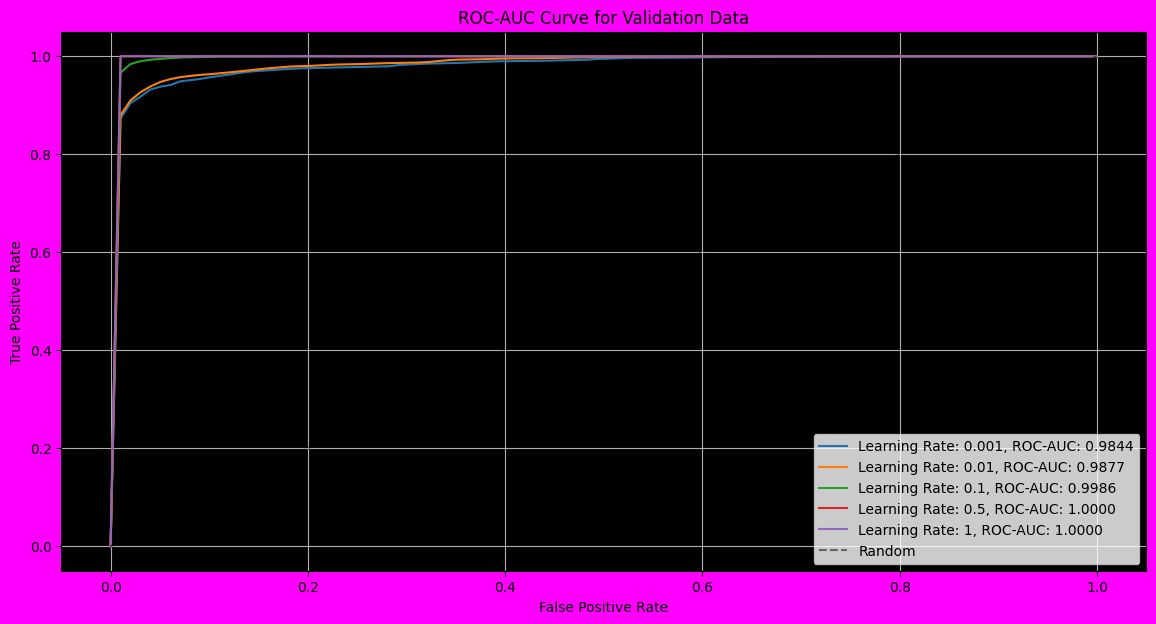

================================================== PLOT END ==================================================


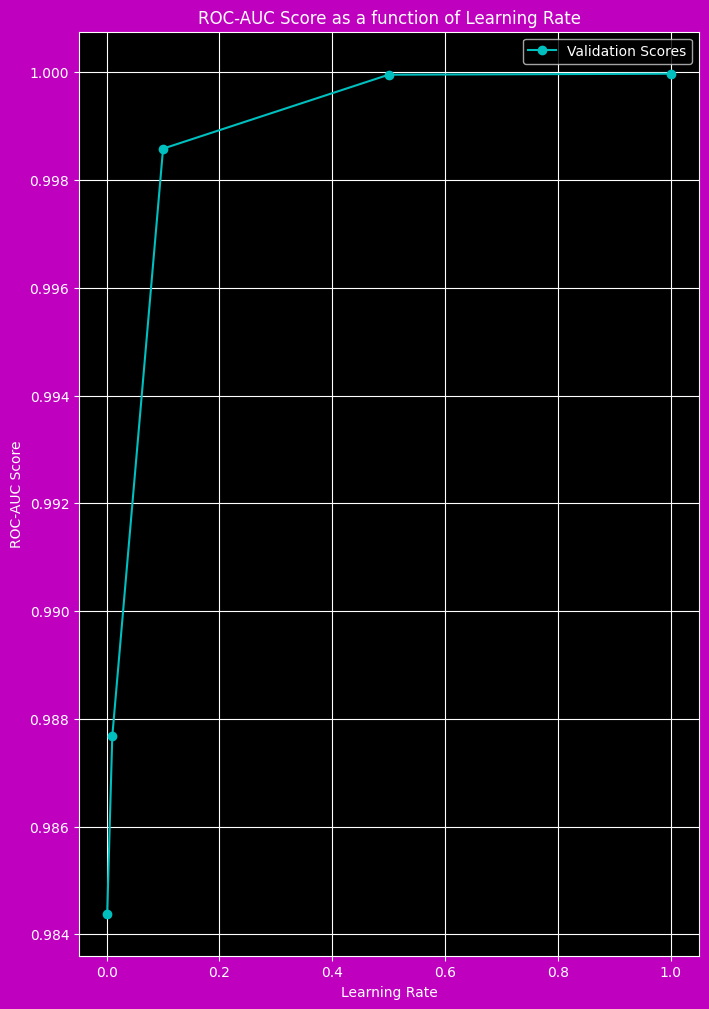



============================================= Performance Summary =============================================
Optimal Learning Rate: 1
ROC-AUC: 1.0000, Precision: 0.9985, Recall: 1.0000, F1 Score: 0.9992


================================================== END ==================================================


In [15]:
print("================================================== START ==================================================")
print("================================================ XGBoost =================================================")

# Set the hyperparameter values for exploration
learning_rate_options = [0.001, 0.01, 0.1, 0.5, 1]

# Lists to store evaluation metrics
roc_auc_vals, precision_vals, recall_vals, f1_vals = [], [], [], []
fixed_fpr = np.linspace(0, 1, 100)

fig, ax2 = plt.subplots(figsize=(14, 7), facecolor='fuchsia')
ax2.set_facecolor('black')

# Evaluate model performance for each learning rate
for rate in learning_rate_options:
    print(f"Processing Learning Rate: {rate}")
    scores, precision, recall, f1, fprs, tprs = [], [], [], [], [], []

    # Cross-validation for current learning rate
    for train_idx, val_idx in skf.split(X_smote_train_pt, y_smote_train_pt):
        start = time.time()
        print(f"Training set: {train_idx}, Validation set: {val_idx}")
        X_cv_train, X_cv_val = X_smote_train_pt[train_idx], X_smote_train_pt[val_idx]
        y_cv_train, y_cv_val = y_smote_train_pt.iloc[train_idx], y_smote_train_pt.iloc[val_idx]

        classifier = xgb.XGBClassifier(learning_rate=rate, n_estimators=100, max_depth=3, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', reg_alpha=0.005, reg_lambda=1, random_state=42)
        classifier.fit(X_cv_train, y_cv_train)

        predictions = classifier.predict_proba(X_cv_val)
        score = roc_auc_score(y_true=y_cv_val, y_score=predictions[:, 1])
        scores.append(score)

        binary_predictions = (predictions[:, 1] >= 0.5).astype(int)
        precision.append(precision_score(y_cv_val, binary_predictions))
        recall.append(recall_score(y_cv_val, binary_predictions))
        f1.append(f1_score(y_cv_val, binary_predictions))

        fpr, tpr, _ = roc_curve(y_true=y_cv_val, y_score=predictions[:, 1])
        tprs.append(interp(fixed_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        print(f"Time Taken for this split: {time.time() - start:.2f} seconds")

    # Averaging the scores across splits
    roc_auc_vals.append(np.mean(scores))
    precision_vals.append(np.mean(precision))
    recall_vals.append(np.mean(recall))
    f1_vals.append(np.mean(f1))

    print(f"Learning Rate: {rate} - ROC-AUC Score: {np.mean(scores):.4f}, Precision: {np.mean(precision):.4f}, Recall: {np.mean(recall):.4f}, F1 Score: {np.mean(f1):.4f}")
    print("================================================== SPLIT END ==================================================")

    # Plotting the ROC curve
    ax2.plot(fixed_fpr, np.mean(tprs, axis=0), label=f'Learning Rate: {rate}, ROC-AUC: {np.mean(scores):.4f}')

print("============================================= XGBoost Completed ==============================================")
print("\n")
print("============================================ ROC-AUC Curve Plot ==============================================")
print("\n")

# Plotting the line for random classifier
ax2.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random', alpha=0.5)

# Setting labels and title
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC-AUC Curve for Validation Data')
ax2.legend(loc="lower right")
ax2.grid(True)

# Displaying the plot
plt.show()

print("================================================== PLOT END ==================================================")

# Plotting ROC-AUC scores against learning rates
with plt.style.context('dark_background'):
    plt.figure(figsize=(8, 12), facecolor='m')
    plt.plot(learning_rate_options, roc_auc_vals, 'co-')
    plt.xlabel('Learning Rate')
    plt.ylabel('ROC-AUC Score')
    plt.title('ROC-AUC Score as a function of Learning Rate')
    plt.legend(['Validation Scores'], loc='upper right')
    plt.grid()
    plt.show()

print("\n")
print("============================================= Performance Summary =============================================")

# Displaying best hyperparameters and their performance
best_idx = np.argmax(roc_auc_vals)
print(f"Optimal Learning Rate: {learning_rate_options[best_idx]}")
print(f"ROC-AUC: {roc_auc_vals[best_idx]:.4f}, Precision: {precision_vals[best_idx]:.4f}, Recall: {recall_vals[best_idx]:.4f}, F1 Score: {f1_vals[best_idx]:.4f}")
print("\n")
print("================================================== END ==================================================")


In [16]:
# Hyperparameters to be explored
hyperparameters = {
    'learning_rate': [0.8, 1, 1.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 0.9],
}

# Setting up the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')

# Note the start time for tuning
tuning_start = time.time()

# Applying GridSearchCV for hyperparameter tuning
grid_search2 = GridSearchCV(xgb_model, 
                           param_grid=hyperparameters, 
                           scoring='roc_auc', 
                           cv=skf, 
                           n_jobs=-1, 
                           verbose=1, 
                           return_train_score=True)

# Fitting the model with the training data
grid_search2.fit(X_smote_train_pt, y_smote_train_pt)

# Note the end time for tuning
tuning_end = time.time()

# Display the time taken for hyperparameter tuning
print(f"Completed hyperparameter tuning in: {tuning_end - tuning_start:.2f} seconds")

# Display the best score achieved
print(f'Optimal ROC AUC Score: {grid_search2.best_score_:.4f}')

# Display the best hyperparameters found
print(f'Optimal Hyperparameters: {grid_search2.best_params_}')


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Completed hyperparameter tuning in: 2869.50 seconds
Optimal ROC AUC Score: 1.0000
Optimal Hyperparameters: {'learning_rate': 0.8, 'max_depth': 5, 'subsample': 0.9}


In [17]:
# Extract cross-validation results
cv_analysis = grid_search2.cv_results_

# Display average scores for each parameter set
print("Average Scores for Different Parameters:")
for score, parameter_set in zip(cv_analysis["mean_test_score"], cv_analysis["params"]):
    print(f"Parameters: {parameter_set} | Score: {score:.4f}")

# Display rankings based on average scores
print("\nParameter Rankings:")
for position, parameter_set in enumerate(cv_analysis["params"]):
    print(f"Rank {position + 1}: {parameter_set}")

# Display variability in scores
print("\nScore Variability:")
for deviation, parameter_set in zip(cv_analysis["std_test_score"], cv_analysis["params"]):
    print(f"Parameters: {parameter_set} | Standard Deviation: {deviation:.4f}")


Average Scores for Different Parameters:
Parameters: {'learning_rate': 0.8, 'max_depth': 3, 'subsample': 0.5} | Score: 1.0000
Parameters: {'learning_rate': 0.8, 'max_depth': 3, 'subsample': 0.7} | Score: 1.0000
Parameters: {'learning_rate': 0.8, 'max_depth': 3, 'subsample': 0.9} | Score: 1.0000
Parameters: {'learning_rate': 0.8, 'max_depth': 5, 'subsample': 0.5} | Score: 1.0000
Parameters: {'learning_rate': 0.8, 'max_depth': 5, 'subsample': 0.7} | Score: 1.0000
Parameters: {'learning_rate': 0.8, 'max_depth': 5, 'subsample': 0.9} | Score: 1.0000
Parameters: {'learning_rate': 0.8, 'max_depth': 7, 'subsample': 0.5} | Score: 1.0000
Parameters: {'learning_rate': 0.8, 'max_depth': 7, 'subsample': 0.7} | Score: 1.0000
Parameters: {'learning_rate': 0.8, 'max_depth': 7, 'subsample': 0.9} | Score: 1.0000
Parameters: {'learning_rate': 1, 'max_depth': 3, 'subsample': 0.5} | Score: 1.0000
Parameters: {'learning_rate': 1, 'max_depth': 3, 'subsample': 0.7} | Score: 1.0000
Parameters: {'learning_rate'